In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import intake 
import pprint
import cftime 
import psutil
import xesmf as xe

In [3]:
regions_dict = {
    'USeast': {'lat': 41.3, 'lon': -72.5},
    'USwest':  {'lat': 37.7, 'lon': -122.4, },
    'iceland':  {'lat': 65, 'lon': -19},
    'europe':  {'lat': 51, 'lon': 10.5},
    'australia': {'lat': -25.2, 'lon': 133.7},
    'tropics': {'lat': 3.9, 'lon': -53.1}
}

In [4]:
from src.multi_model_large_ensemble import MultiModelLargeEnsemble

In [5]:
mmle = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR', 'EC-Earth3'], 'tasmax', 'day', 
                               lat= -25.2, lon=133.7, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [6]:
region = 'australia'
mmle_qdm = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR', 'EC-Earth3'], 'tasmax', 'day', 
                               lat= -25.2, lon=133.7, 
                               bucket='climateai_data_repository', path=f'tmp/qdm_{region}')

In [8]:
mmle.compute_x(x_type='quantile_return', load=True, return_period=10, hist_slice=slice('2005', '2014'))

File not found, computing new


100%|██████████| 1/1 [00:09<00:00,  9.76s/it]

3.0620956420898438


3.105175018310547


3.1138877868652344


3.0929222106933594


/opt/conda/envs/carla/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/opt/conda/envs/carla/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))





3.109630584716797


In [11]:
mmle_qdm.compute_x(x_type='quantile_return', load=True, return_period=10, hist_slice=slice('2005', '2014'))

File not found, computing new


3.1913909912109375


3.152751922607422


3.123340606689453









100%|██████████| 1/1 [00:00<00:00,  1.48it/s]









3.143199920654297


/opt/conda/envs/carla/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/opt/conda/envs/carla/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))









3.1509361267089844


In [9]:
mmle.compute_LE()

/opt/conda/envs/carla/lib/python3.9/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [12]:
mmle_qdm.compute_LE()

/opt/conda/envs/carla/lib/python3.9/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [10]:
mmle.results

<xarray.Dataset>
Dimensions:   (time: 96, lat: 1, lon: 1, model: 5)
Coordinates:
  * time      (time) datetime64[ns] 2005-01-01 2006-01-01 ... 2100-01-01
  * lat       (lat) float64 -25.0
  * lon       (lon) float64 132.5
  * model     (model) <U13 'MIROC6' 'cesm_lens' ... 'MPI-ESM1-2-LR' 'EC-Earth3'
    quantile  (model) float64 0.9997 0.9997 0.9997 0.9997 0.9997
    q_values  (model, lat, lon) float64 331.4 315.7 326.0 318.8 318.8
Data variables:
    M_LE      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    I_LE      (model, time, lat, lon) float64 nan nan nan nan ... nan nan nan
    Ibar_LE   (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    T_LE      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

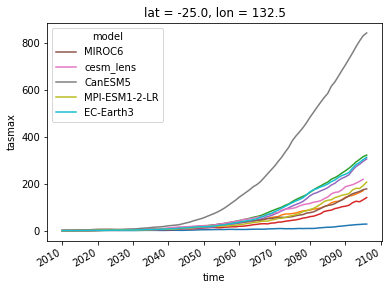

In [13]:
mmle.x.mean('member_id').isel(lat=0, lon=0).plot(hue='model')
mmle_qdm.x.mean('member_id').isel(lat=0, lon=0).plot(hue='model')

In [14]:
from src.post_p_large_ensemble import qdm_large_ensemble
era2cmip = {
    't2m': 'tas',
    't2m_max': 'tasmax',
    't2m_min': 'tasmin',
    'tp': 'pr',
    'huss': 'huss',  # Specific humidity does not exist in ERA, so just mapping CMIP to CMIP
    # 'd2m': 'tdps',
    'ws': 'sfcWind',
    'sm': 'mrsos'  # https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2020GL089991
}

cmip2era = {v: k for k, v in era2cmip.items()}

In [15]:
variable = 'tasmax'
region = 'australia'
path = f'gcs://climateai_data_repository/tmp/internal_variability/era_files/{region}/reanalysis_daily.zarr'
reanalysis_daily = xr.open_zarr(path, consolidated=True).load()


In [18]:
reanalysis_daily[cmip2era[variable]]+=273.15

In [19]:

large_ens_hist = qdm_large_ensemble(
    mmle.hist_dsets,
    mmle.hist_dsets,
    reanalysis_daily[cmip2era[variable]]
)

CanESM5 has been post-processed
EC-Earth3 has been post-processed
MIROC6 has been post-processed
MPI-ESM1-2-LR has been post-processed
cesm_lens has been post-processed


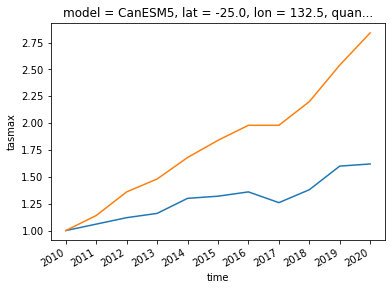

In [15]:
mmle.x.mean('member_id').isel(lat=0, lon=0).sel(model='CanESM5').sel(time=slice(None, '2020')).plot()
mmle_qdm.x.mean('member_id').isel(lat=0, lon=0).sel(model='CanESM5').sel(time=slice(None, '2020')).plot()

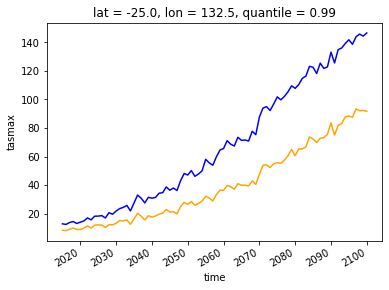

In [22]:
(mmle_qdm.future_dsets['CanESM5'].load()>mmle_qdm.hist_dsets['CanESM5'].load().quantile(0.99, ('time'))).resample(time='AS').sum().mean('member_id').plot(color='blue')
(mmle.future_dsets['CanESM5'].load()>mmle.hist_dsets['CanESM5'].load().quantile(0.99, ('time'))).resample(time='AS').sum().mean('member_id').plot(color='orange')

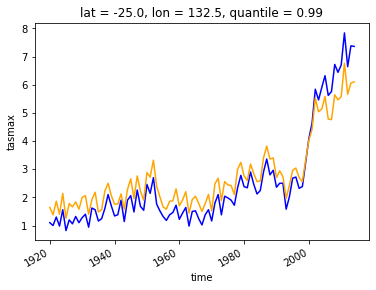

In [29]:
(mmle_qdm.hist_dsets['CanESM5'].load()>mmle_qdm.hist_dsets['CanESM5'].sel(time=slice('1979', '2010')).load().quantile(0.99, ('time'))).resample(time='AS').sum().mean('member_id').plot(color='blue')
(mmle.hist_dsets['CanESM5'].load()>mmle.hist_dsets['CanESM5'].sel(time=slice('1979', '2010')).load().quantile(0.99, ('time'))).resample(time='AS').sum().mean('member_id').plot(color='orange')

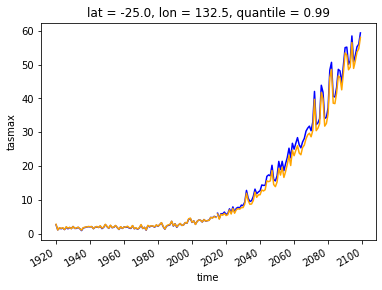

In [27]:

(mmle_qdm.hist_dsets['cesm_lens'].load()>mmle_qdm.hist_dsets['cesm_lens'].sel(time=slice('2000', '2010')).load().quantile(0.99, ('time'))).resample(time='AS').sum().mean('member_id').plot(color='blue')
(mmle.hist_dsets['cesm_lens'].load()>mmle.hist_dsets['cesm_lens'].sel(time=slice('2000', '2010')).load().quantile(0.99, ('time'))).resample(time='AS').sum().mean('member_id').plot(color='orange')

(mmle_qdm.future_dsets['cesm_lens'].load()>mmle_qdm.hist_dsets['cesm_lens'].sel(time=slice('2000', '2010')).load().quantile(0.99, ('time'))).resample(time='AS').sum().mean('member_id').plot(color='blue')
(mmle.future_dsets['cesm_lens'].load()>mmle.hist_dsets['cesm_lens'].sel(time=slice('2000', '2010')).load().quantile(0.99, ('time'))).resample(time='AS').sum().mean('member_id').plot(color='orange')

In [ ]:

mmle_qdm.hist_dsets['MIROC6'].quantile(0.99, ('time'))).resample(time='AS').sum().mean('member_id').plot(color='blue')
mmle.hist_dsets['MIROC6'].quantile(0.99, ('time'))).resample(time='AS').sum().mean('member_id').plot(color='orange')

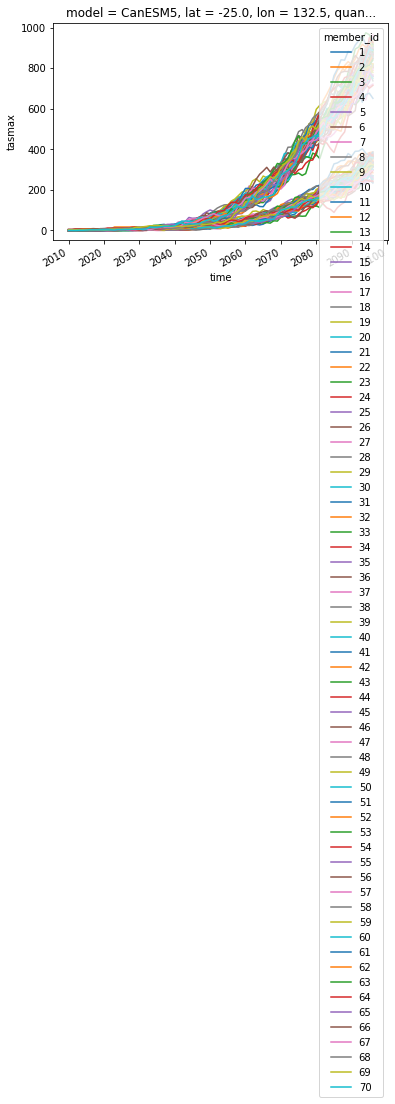

In [40]:
mmle.x.sel(model = 'CanESM5').isel(lat=0, lon=0).plot(hue='member_id')
mmle_qdm.x.sel(model = 'CanESM5').isel(lat=0, lon=0).plot(hue='member_id')


In [17]:
mmle_qdm.x.model

<xarray.DataArray 'model' (model: 5)>
array(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR', 'EC-Earth3'],
      dtype='<U13')
Coordinates:
  * model    (model) <U13 'MIROC6' 'cesm_lens' ... 'MPI-ESM1-2-LR' 'EC-Earth3'

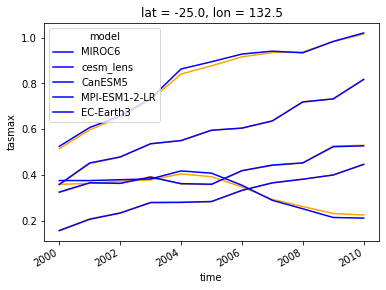

In [15]:

mmle_qdm.x.mean('member_id').sel(time=slice('2000', '2010')).isel(lat=0, lon=0).plot(hue='model', color='orange')
mmle.x.mean('member_id').sel(time=slice('2000', '2010')).isel(lat=0, lon=0).plot(hue='model', color='blue')


In [19]:
path = f'gcs://climateai_data_repository/tmp/internal_variability/era_files/{region}/reanalysis_daily.zarr'
reanalysis_daily = xr.open_zarr(path, consolidated=True).load()

In [20]:
reanalysis_daily['t2m_max'] += 273.15

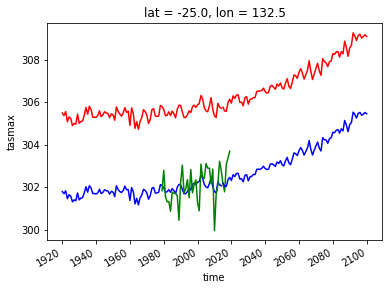

In [73]:
mmle_qdm.hist_dsets['MIROC6'].load().resample(time='AS').mean().mean('member_id').plot(color='blue');
mmle.hist_dsets['MIROC6'].load().resample(time='AS').mean().mean('member_id').plot(color='red');
reanalysis_daily['t2m_max'].resample(time='As').mean().plot(color='green');
mmle_qdm.future_dsets['MIROC6'].load().resample(time='AS').mean().mean('member_id').plot(color='blue');
mmle.future_dsets['MIROC6'].load().resample(time='AS').mean().mean('member_id').plot(color='red');